# Tempogram: Fourier, Autocorrelation, Cyclic

Compute three tempogram variants (Fourier, autocorrelation, cyclic) from the spectral novelty function for YTB-013 HEAD_IN, using [FMP C6S2_TempogramFourier](notebooks/fmp/C6S2_TempogramFourier.ipynb), [C6S2_TempogramAutocorrelation](notebooks/fmp/C6S2_TempogramAutocorrelation.ipynb), and [C6S2_TempogramCyclic](notebooks/fmp/C6S2_TempogramCyclic.ipynb) as reference.

In [1]:
import sys
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Add project root for dijon imports
project_root = Path.cwd()
if not (project_root / "src" / "dijon").exists():
    project_root = project_root.parent.parent
sys.path.insert(0, str(project_root))

from dijon.global_config import DERIVED_DIR, RAW_AUDIO_DIR
from dijon.tempogram import (
    compute_cyclic_tempogram,
    compute_tempogram_autocorr,
    compute_tempogram_fourier,
)

%matplotlib inline

In [2]:
TRACK = "YTB-005"
MARKER = ""  # "" or None = full track; else e.g. "HEAD_IN", "LICK01"
MARKER_LABEL = "FULL" if not (MARKER and str(MARKER).strip()) else str(MARKER).upper().replace("-", "_")
WRITE_OUTPUT = False  # set True to save tempograms to data/derived/tempogram/
FS_NOV = 100  # target feature rate for tempogram (matches FMP reference)
H_SPECTRAL = 256  # hop size used when computing spectral novelty in novelty.ipynb

# Load spectral novelty only
novelty_path = DERIVED_DIR / "novelty" / f"{TRACK}_{MARKER_LABEL}_spectral.npy"
novelty_spec = np.load(novelty_path)

# Get sample rate from audio to compute original feature rate
audio_path = RAW_AUDIO_DIR / f"{TRACK}.wav"
_, sr = librosa.load(audio_path, sr=None, mono=True, duration=0.1)
Fs_spec = sr / H_SPECTRAL

# Resample novelty to 100 Hz
t_in = np.arange(len(novelty_spec)) / Fs_spec
duration_s = len(novelty_spec) / Fs_spec
n_out = int(duration_s * FS_NOV)
t_out = np.linspace(0, duration_s, n_out, endpoint=False)
interp = interp1d(t_in, novelty_spec, kind="linear", fill_value="extrapolate")
nov = interp(t_out).astype(np.float64)
print(f"Spectral novelty: {len(novelty_spec)} frames @ {Fs_spec:.1f} Hz -> {len(nov)} @ {FS_NOV} Hz")

Spectral novelty: 15116 frames @ 86.1 Hz -> 17549 @ 100 Hz


In [3]:
N = 500  # 5 seconds at 100 Hz
H = 10
Theta = np.arange(40, 321, dtype=np.float64)  # 40–320 BPM

# Fourier tempogram
X, T_coef, F_coef_BPM = compute_tempogram_fourier(nov, FS_NOV, N=N, H=H, Theta=Theta)
tempogram_fourier = np.abs(X)

# Autocorrelation tempogram
tempogram_autocorr, T_coef_A, F_coef_BPM_A = compute_tempogram_autocorr(
    nov, FS_NOV, N=N, H=H, Theta=Theta
)

# Cyclic tempogram (built from Fourier tempogram)
tempogram_cyclic, F_coef_scale = compute_cyclic_tempogram(
    tempogram_fourier, F_coef_BPM, tempo_ref=40, octave_bin=40, octave_num=4
)

/var/folders/n3/fk41_zd57m79jjjprfznr8680000gn/T/ipykernel_86112/809802019.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])


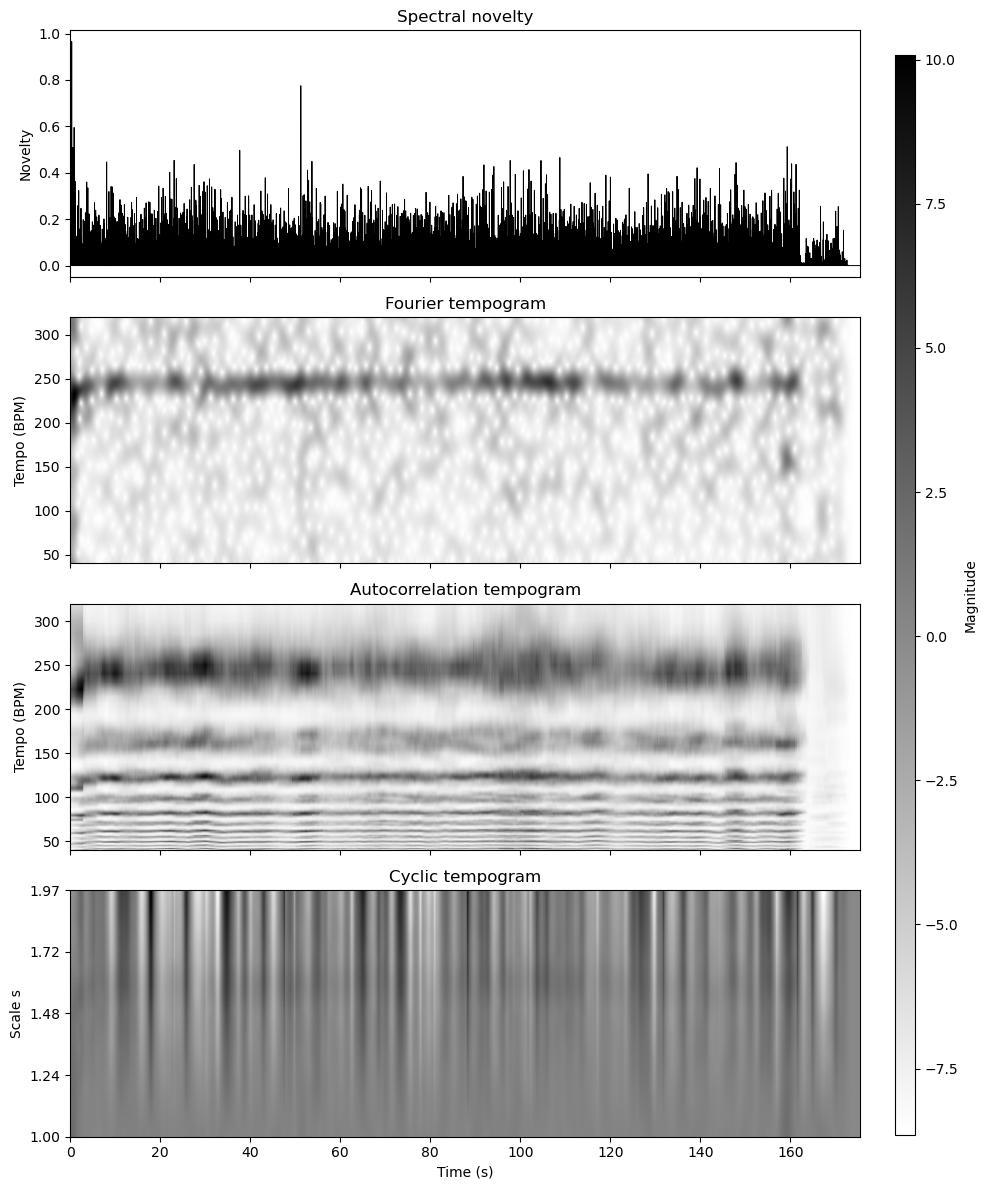

In [4]:
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

t_nov = np.arange(len(nov)) / FS_NOV

# Novelty function
axes[0].plot(t_nov, nov, "k", linewidth=0.7)
axes[0].set_title("Spectral novelty")
axes[0].set_xlim(0, t_nov[-1])
axes[0].set_ylabel("Novelty")

# Fourier tempogram
im1 = axes[1].imshow(
    tempogram_fourier,
    aspect="auto",
    origin="lower",
    extent=[T_coef[0], T_coef[-1], F_coef_BPM[0], F_coef_BPM[-1]],
    cmap="gray_r",
)
axes[1].set_title("Fourier tempogram")
axes[1].set_ylabel("Tempo (BPM)")

# Autocorrelation tempogram
im2 = axes[2].imshow(
    tempogram_autocorr,
    aspect="auto",
    origin="lower",
    extent=[T_coef_A[0], T_coef_A[-1], F_coef_BPM_A[0], F_coef_BPM_A[-1]],
    cmap="gray_r",
)
axes[2].set_title("Autocorrelation tempogram")
axes[2].set_ylabel("Tempo (BPM)")

# Cyclic tempogram (y-axis: scale factor s in [1, 2))
im3 = axes[3].imshow(
    tempogram_cyclic,
    aspect="auto",
    origin="lower",
    extent=[T_coef[0], T_coef[-1], F_coef_scale[0], F_coef_scale[-1]],
    cmap="gray_r",
)
axes[3].set_title("Cyclic tempogram")
axes[3].set_xlabel("Time (s)")
axes[3].set_ylabel("Scale s")
yticks = np.linspace(F_coef_scale[0], F_coef_scale[-1], 5)
axes[3].set_yticks(yticks)
axes[3].set_yticklabels([f"{y:.2f}" for y in yticks])

cax = fig.add_axes([0.9, 0.05, 0.02, 0.9])
fig.colorbar(im3, cax=cax, label="Magnitude")
plt.tight_layout(rect=[0, 0, 0.88, 1])

In [5]:
# Save tempograms to data/derived/tempogram (naming: {TRACK}_{MARKER_LABEL}_{variant}.npy)
tempogram_dir = DERIVED_DIR / "tempogram"
tempogram_dir.mkdir(parents=True, exist_ok=True)
if WRITE_OUTPUT:
    np.save(tempogram_dir / f"{TRACK}_{MARKER_LABEL}_fourier.npy", tempogram_fourier)
    np.save(tempogram_dir / f"{TRACK}_{MARKER_LABEL}_autocorr.npy", tempogram_autocorr)
    np.save(tempogram_dir / f"{TRACK}_{MARKER_LABEL}_cyclic.npy", tempogram_cyclic)